# Data Science - Micro Project
**Course**: CS1U31G (_Applied Data Science with Python_)

**Submitted By**: Abhinav Prakash (B21CS1203)

**Topic**: Using a deep learning based sequence model to predict the next likely words given an incomplete sentence as the input.

## Overview

* ### [1. Load the Data](#load-the-data)
* ### [2. Overview of the Data](#data-cleaning)
* ### [3. Exploratory Data Analysis](#exploratory-data-analysis)
* ### [4. Data Preparation](#data-preparation)
* ### [5. Model Building](#model-building)
* ### [6. Improve Model](#improve-model)

# 1. Load the Data <a class="anchor" id="load-the-data"></a>

We use the popular drama/indie screenplay: *Good Will Hunting* as our training corpus. This corpus comprises of 3293 unique words in total.

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential

import numpy as np 

In [37]:
file = open("./corpus/Goodwill.txt").read()

# 2. Overview of the Data <a class="anchor" id="overview-of-the-data"></a>

## 2.1 Descriptive Statistics

In [38]:
data = file.lower().split("\n")

In [39]:
data[:20]

['   good will hunting',
 '           by',
 'matt damon & ben affleck',
 '',
 'fade in:',
 "ext. south boston st. patrick's day parade -- day cut to:",
 'int. l street bar & grille, south boston -- evening',
 "the bar is dirty, more than a little run down. if there is ever a cook on duty, he's not here now. as we pan across several empty tables, we can almost smell the odor of last nights beer and crushed pretzels on the floor.",
 '                               chuckie',
 '            oh my god, i got the most fucked up',
 "thing i been meanin' to tell you.",
 'as the camera rises, we find four young men seated around a table near the back of the bar.',
 'all oh jesus. here we go.',
 "the guy holding court is chuckie sullivan, 20, and the largest of the bunch. he is loud, boisterous, a born entertainer. next to him is will hunting, 20, handsome and confident, a soft- spoken leader. on will's right sits billy mcbride, 22, heavy, quiet, someone you definitely wouldn't want to tangle wit

In [40]:
print(f"No of lines: {len(data)}");

No of lines: 3637


# 3. Exploratory Data Analysis <a class="anchor" id="exploratory-data-analysis"></a>

In [41]:
import re
from collections import Counter
import matplotlib.pyplot as plt

In [42]:
def plot_histogram(words_freq):
    words, freq = zip(*words_freq)
    plt.figure(figsize=(10, 6))
    plt.bar(words, freq)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Histogram')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Counter({'the': 856, 'will': 765, 'you': 763, 'i': 684, 'a': 625, 'to': 619, 'and': 489, 's': 488, 'sean': 367, 't': 296, 'that': 295, 'it': 283, 'lambeau': 279, 'of': 276, 'is': 273, 'in': 267, 'chuckie': 235, 'he': 234, 'skylar': 175, 'd': 168, 'what': 165, 'me': 153, 'with': 151, 'on': 149, 'his': 148, 'my': 145, 'at': 143, 'up': 141, 'this': 134, 'm': 133, 'cont': 130, 'for': 130, 'don': 128, 're': 125, 'have': 122, 'do': 121, 'out': 119, 'your': 117, 'beat': 110, 'we': 108, 'not': 104, 'know': 103, 'morgan': 102, 'so': 93, 'can': 92, 'about': 85, 'be': 85, 'all': 84, 'there': 82, 'him': 82, 'they': 82, 'was': 80, 'but': 79, 'one': 77, 'int': 76, 'as': 75, 'cut': 74, 'back': 73, 'are': 73, 'like': 73, 'just': 73, 'from': 73, 'want': 70, 'no': 70, 'if': 69, 'get': 67, 'an': 67, 'look': 65, 'here': 62, 'who': 62, 'got': 59, 'right': 59, 'day': 58, 'why': 57, 'fuckin': 55, 'now': 53, 'think': 53, 'she': 53, 'how': 52, 'ext': 51, 'll': 51, 'well': 50, 'go': 49, 'see': 49, 'been': 48, '

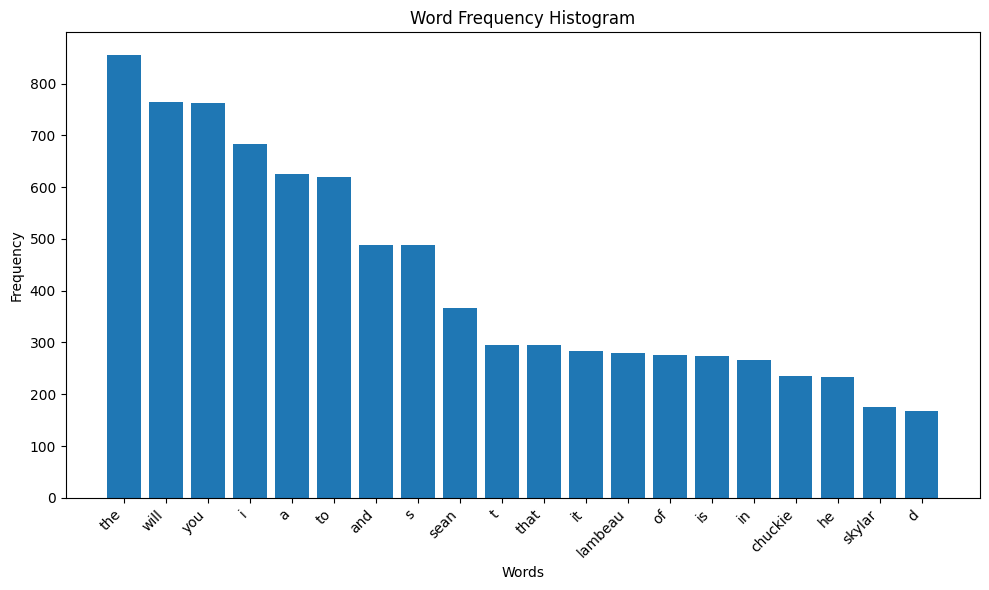

In [45]:
words = []
for line in data:
  words.extend(re.findall(r'\b\w+\b', line.lower()))

word_freq = Counter(words)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(f"{word_freq}")
plot_histogram(sorted_word_freq[:20])

# 4. Data Preparation <a class="anchor" id="data-preparation"></a>

## 4.1 Data Cleaning

### 4.1.1 Removing Whitespace from the data:

In [44]:
corpus = []
for line in data:
    a = line.strip()
    corpus.append(a)

In [25]:
corpus[0:20]

['good will hunting',
 'by',
 'matt damon & ben affleck',
 '',
 'fade in:',
 "ext. south boston st. patrick's day parade -- day cut to:",
 'int. l street bar & grille, south boston -- evening',
 "the bar is dirty, more than a little run down. if there is ever a cook on duty, he's not here now. as we pan across several empty tables, we can almost smell the odor of last nights beer and crushed pretzels on the floor.",
 'chuckie',
 'oh my god, i got the most fucked up',
 "thing i been meanin' to tell you.",
 'as the camera rises, we find four young men seated around a table near the back of the bar.',
 'all oh jesus. here we go.',
 "the guy holding court is chuckie sullivan, 20, and the largest of the bunch. he is loud, boisterous, a born entertainer. next to him is will hunting, 20, handsome and confident, a soft- spoken leader. on will's right sits billy mcbride, 22, heavy, quiet, someone you definitely wouldn't want to tangle with. finally there is morgan o'mally, 19, smaller than the 

### 4.1.2 Tokenizing

In [30]:
tokenizer = Tokenizer()

In [31]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'will': 2, 'you': 3, 'a': 4, 'to': 5, 'i': 6, 'and': 7, 'sean': 8, 'of': 9, 'is': 10, 'lambeau': 11, 'in': 12, 'that': 13, 'chuckie': 14, 'he': 15, 'it': 16, 'skylar': 17, 'me': 18, 'with': 19, 'on': 20, 'his': 21, 'what': 22, 'my': 23, 'at': 24, 'up': 25, 'this': 26, "cont'd": 27, 'for': 28, "don't": 29, 'have': 30, 'do': 31, 'out': 32, "i'm": 33, 'your': 34, 'beat': 35, 'not': 36, 'know': 37, 'morgan': 38, 'so': 39, "it's": 40, "you're": 41, 'about': 42, 'be': 43, 'all': 44, 'him': 45, 'we': 46, 'was': 47, 'but': 48, 'int': 49, 'as': 50, 'one': 51, 'cut': 52, 'back': 53, 'are': 54, 'like': 55, 'just': 56, 'from': 57, 'want': 58, 'they': 59, 'no': 60, 'if': 61, 'can': 62, 'get': 63, 'an': 64, 'there': 65, 'look': 66, "that's": 67, 'here': 68, 'got': 69, 'right': 70, 'who': 71, 'day': 72, 'why': 73, 'now': 74, "fuckin'": 75, 'think': 76, 'ext': 77, 'well': 78, 'go': 79, 'see': 80, 'been': 81, 'over': 82, 'when': 83, "will's": 84, 'how': 85, 'down': 86, 'night': 87, 'yeah': 8

### 4.1.2 Creating Predictors and Labels

In [32]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# Padding the sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Creating predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# 5. Model Building <a class="anchor" id="model-building"></a>

In [33]:
model = Sequential([Embedding(total_words, 100, input_length = max_sequence_len-1),
                    Bidirectional(LSTM(150)),
                    Dense(total_words, activation = 'softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 5.1 Model Training 

In [49]:
history = model.fit(xs, ys, epochs=30, verbose=1)

Epoch 1/3
 78/628 [==>...........................] - ETA: 2:28 - loss: 4.9057 - accuracy: 0.1330

KeyboardInterrupt: 

## 5.2 Model Prediction

Creating a function to predict the next word given a seed sentence.

In [33]:
def next_word(seed):
  seed_text = seed
  next_words = 1
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word
  print(seed_text)

In [28]:
next_word('Lets go')

Lets go out


In [30]:
next_word('I want to meet')

I want to meet your


In [34]:
next_word('Congratulations')

Congratulations thank you


In [35]:
next_word('Where are ')

Where are  you from


## 5.3 Model Evaluation

### 5.3.1 Plotting the training accuracy of the model

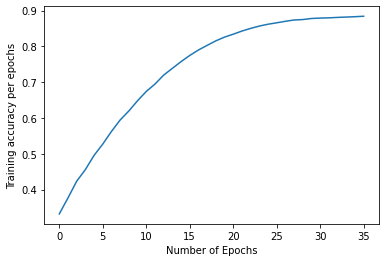

In [17]:
plt.plot(history.history['accuracy'])
plt.xlabel("Number of Epochs")
plt.ylabel('Training accuracy per epochs')
plt.show()

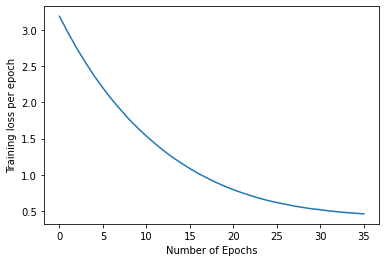

In [18]:
plt.plot(history.history['loss'])
plt.xlabel("Number of Epochs")
plt.ylabel('Training loss per epoch')
plt.show()

# 6. Improve Model <a class="anchor" id="improve-model"></a>

## 6.1 Hyper-Parameter Tuning

In [47]:
import keras_tuner as kt
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [48]:
def model_builder(hp):
  model = Sequential()
  model.add(Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units, activation='relu'))
  model.add(Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

In [ ]:
tuner.search(xs, ys, epochs=30, validation_split=0.2)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Now we create an updated model.

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(xs, ys, epochs=30, validation_split=0.2)

## 6.2 Save the final model

In [ ]:
model.save("./model/next-word-model.h5")